In [5]:
import mpld3
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.decomposition import PCA
from astropy.table import Table
import pandas as pd

In [29]:
# helpers
def flag_on(value, flag):
    return (value & flag) == flag

In [30]:
def bitfield(n):
    return [1 if digit=='1' else 0 for digit in bin(n)[2:]][::-1] # [2:] to chop off the "0b" part

bitfield(393216)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]

In [31]:
from itertools import zip_longest

def add_bitfields(x, y):
    return [a + b for (a, b) in zip_longest(x, y, fillvalue=0)]

print(bitfield(52))
print(bitfield(98))
addBitfields(bitfield(52), bitfield(98))

[0, 0, 1, 0, 1, 1]
[0, 1, 0, 0, 0, 1, 1]


[0, 1, 1, 0, 1, 2, 1]

In [32]:
def add_integers_as_bitfields(x, y):
    return add_bitfields(bitfield(x), bitfield(y))

add_integers_as_bitfields(52, 98)

[0, 1, 1, 0, 1, 2, 1]

In [42]:
path = '/srv/scratch/astro/z3529659/eleanor-lite/s0001/0000/0000/2419/5205/hlsp_gsfc-eleanor-lite_tess_ffi_s0001-0000000024195205_tess_v1.0_lc.fits'
f = fits.open(path)
print(f[0].header['TIC_ID'])
a = Table.read(f[1])
a_pd = a.to_pandas()

24195205


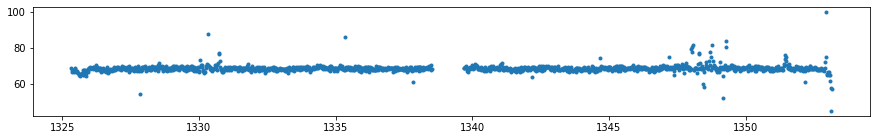

In [34]:
plt.figure(figsize=(15,2))
sf = a_pd['PCA_FLUX'].tolist()
t = a_pd['TIME'].tolist()

plt.plot(t, sf, '.')

In [43]:
type(a_pd['QUALITY'][0]) # numpy.int64
a_pd['QUALITY'][0].item()
bitfield(a_pd['QUALITY'][0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]

In [36]:
bin(a_pd['QUALITY'][0])

'0b1100000000000000000'

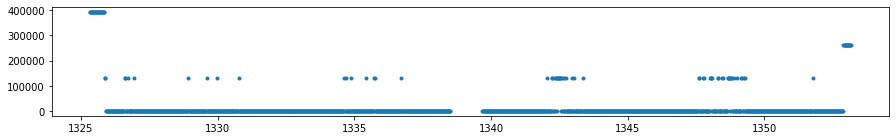

In [44]:
plt.figure(figsize=(15,2))
sf = a_pd['QUALITY'].tolist()
t = a_pd['TIME'].tolist()

plt.plot(t, sf, '.')

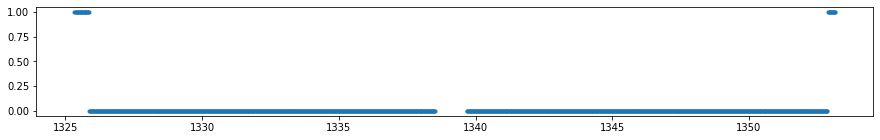

In [48]:
bit_18_list = [1 if flag_on(x, 2**18) else 0 for x in a_pd['QUALITY']]
plt.figure(figsize=(15,2))
t = a_pd['TIME'].tolist()

plt.plot(t, bit_18_list, '.')

In [51]:
def check_specific_flag(quality, flag_bit):
    return [1 if flag_on(x, 2**flag_bit) else 0 for x in quality]

In [ ]:
# Create a dataset of all the lightcurves in s0017/0000/0000/05*
mask = 0
data_dict = {}
quality_flags = []
for path in glob('/srv/scratch/astro/z3529659/eleanor-lite/s0001/0000/0000/24*/*/*.fits'):
    with fits.open(path) as fits_file:
        # series = pd.Series(fits_data[1].data['SAP_FLUX'].byteswap().newbyteorder(), index=fits_data[1].data['TIME'])
        dat = Table.read(fits_file[1])
        pd_dat = dat.to_pandas()

        data_dict[f"TIC {fits_file[0].header['TIC_ID']}"] = pd_dat['PCA_FLUX']/np.nanmedian(pd_dat['PCA_FLUX'])
        quality_flags.append(pd_dat['QUALITY'])
df = pd.DataFrame(data_dict)


In [65]:
df.shape[1]

4643

In [52]:
bit_18_aggregate = []
for quality in quality_flags:
    bit_18_aggregate = add_bitfields(bit_18_aggregate, check_specific_flag(quality, 18))

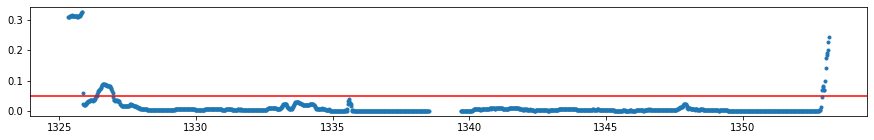

In [72]:
plt.figure(figsize=(15,2))

plt.plot(a_pd['TIME'].tolist(), list(map(lambda x: x / df.shape[1], bit_18_aggregate)), '.')
plt.axhline(y=0.05, color='r', linestyle='-')

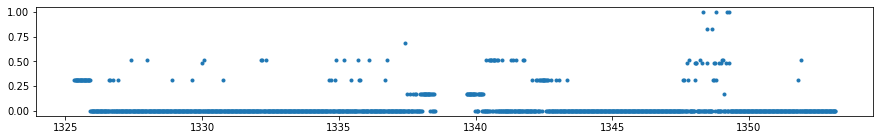

In [73]:
bit_17_aggregate = []
for quality in quality_flags:
    bit_17_aggregate = add_bitfields(bit_17_aggregate, check_specific_flag(quality, 17))
plt.figure(figsize=(15,2))

plt.plot(a_pd['TIME'].tolist(), list(map(lambda x: x / df.shape[1], bit_17_aggregate)), '.')

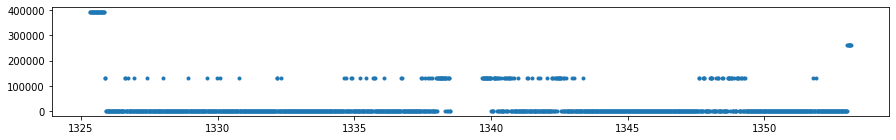

In [75]:
overall_quality = [0] * len(quality_flags[0])
for bit_num in range(19):
    bit_aggregate = []
    for quality in quality_flags:
        bit_aggregate = add_bitfields(bit_aggregate, check_specific_flag(quality, bit_num))
        
    for (i, x) in enumerate(bit_aggregate):
        if x / df.shape[1] > 0.1:
            overall_quality[i] |= 2**bit_num
            
            
plt.figure(figsize=(15,2))

plt.plot(a_pd['TIME'].tolist(), overall_quality, '.')

In [8]:
format(mask[0], 'b')
# mask[0]
a = 393216
flag_on(a, 2**17)
init_mask = mask

In [9]:
mask = flag_on(mask, 2**17)

In [10]:
df

,TIC 24750104,TIC 24750125,TIC 24750429,TIC 24751262,TIC 24750150,TIC 24750735,TIC 24750921,TIC 24750570,TIC 24750521,TIC 24751013,...,TIC 24231925,TIC 24232348,TIC 24232204,TIC 24231294,TIC 24231449,TIC 24232060,TIC 24231881,TIC 24231980,TIC 24231918,TIC 24232048
0,1.017117,1.002497,1.025681,1.004982,1.062410,0.987871,1.062835,1.012465,1.007513,1.031128,...,1.015025,1.035393,1.011026,1.021082,0.998248,1.031264,0.993463,0.999922,1.022889,1.007665
1,1.007696,1.000937,1.024760,1.005951,1.023847,0.996035,1.051456,1.002076,1.006554,1.028640,...,1.015810,1.035486,1.007262,1.023405,0.999193,1.014825,0.993090,0.993570,1.007428,1.002762
2,1.003661,1.000884,1.009341,1.002183,0.996834,1.002518,1.026858,0.998148,1.006100,1.021496,...,1.012134,1.038784,1.006310,1.018177,0.997933,1.024628,1.018710,0.993312,0.997709,1.002196
3,0.999916,1.000075,0.997247,1.003411,0.988325,0.981217,1.048688,0.996655,1.007088,1.022753,...,1.013462,1.036662,1.012626,1.008900,0.998966,1.029112,1.019859,0.991863,1.001787,0.999123
4,1.001238,1.000149,0.995174,1.001830,0.984678,0.970466,1.038756,0.994077,1.007272,1.014839,...,1.009596,1.021233,1.017349,1.008828,0.995720,1.001084,1.025201,0.988115,0.999357,0.996196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277,1.001031,0.999156,0.994494,1.001822,0.991452,0.980167,0.985452,0.994350,1.000704,0.997954,...,0.972475,0.921744,0.944078,0.982678,1.018254,1.030345,0.864266,1.029997,1.051327,0.993106
1278,1.000865,0.999433,1.000843,0.999719,1.005733,1.012021,1.014415,0.996135,0.999326,0.998852,...,0.905372,0.886116,0.948955,0.977225,1.004425,0.907931,0.767540,1.005393,0.725358,0.945222
1279,1.000540,0.999286,0.997578,0.999163,1.009154,1.000003,0.997601,0.998617,0.999873,0.994922,...,0.909664,0.834996,0.954908,0.956885,1.028512,0.864535,1.349457,1.031855,0.807894,0.914058
1280,1.006451,0.999764,1.009089,1.001457,1.034518,1.009357,0.976584,1.003029,0.999498,1.000539,...,0.975870,0.855752,0.961515,0.945711,1.026515,0.885823,0.889987,1.047307,1.113036,0.956055


In [77]:
df.shape

(1282, 4643)

In [76]:
df_masked = df[pd.Series(overall_quality) == 0]

In [78]:
df_masked.shape

(923, 4643)

In [79]:
from sklearn.impute import SimpleImputer
imp_constant = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=1)
imputed_sample = imp_constant.fit_transform(df_masked.transpose())

In [80]:
pca = PCA(n_components=2)
sample_after_pca = pca.fit(imputed_sample).transform(imputed_sample)

In [81]:
sample_after_pca.shape

(4643, 2)

In [82]:
pca.explained_variance_ratio_

array([0.50109118, 0.21826811])

In [83]:

labels = list(df.columns)
fig = plt.figure()
scatter = plt.scatter(
    sample_after_pca[:, 0], sample_after_pca[:, 1], s=5, label=labels
)

plt.title("PCA of lightcurves in s0001/0000/0000/24*")

tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

Outliers are:
* (bottom right) TIC 24293868 https://exofop.ipac.caltech.edu/tess/target.php?id=24293868
* (top left) TIC 24293871 https://exofop.ipac.caltech.edu/tess/target.php?id=24293871
* (bottom left) TIC 24694341 https://exofop.ipac.caltech.edu/tess/target.php?id=24694341

/apps/python/3.7.4/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/apps/python/3.7.4/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/apps/python/3.7.4/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


(0.2, 1.8)

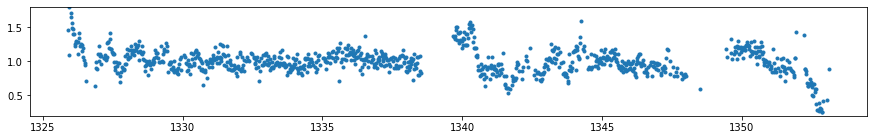

In [84]:
rando = fits.open(glob('/srv/scratch/astro/z3529659/eleanor-lite/s0001/0000/0000/2429/3871/*.fits')[0])
dat = Table.read(rando[1])
dat_pd = dat.to_pandas()
dat_pd = dat_pd[dat_pd['QUALITY'] == 0]

plt.figure(figsize=(15,2))
sf = dat_pd['PCA_FLUX']
t = dat_pd['TIME']

plt.plot(t, sf/np.nanmedian(sf), '.')
plt.ylim(0.2, 1.8)

# instrumental
# period of 1 day - rotation of the earth - scattered light from the Earth
# Quality flags: 18 and 19 - eleanor. 0-17 - TESS

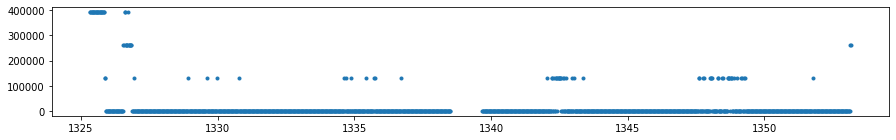

In [85]:
rando = fits.open(glob('/srv/scratch/astro/z3529659/eleanor-lite/s0001/0000/0000/2429/3871/*.fits')[0])
dat = Table.read(rando[1])
dat_pd = dat.to_pandas()
plt.figure(figsize=(15,2))
sf = dat_pd['QUALITY']
t = dat_pd['TIME']

plt.plot(t, sf, '.')

(0.8, 1.2)

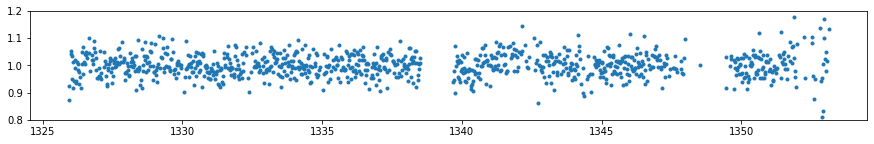

In [86]:
rando = fits.open(glob('/srv/scratch/astro/z3529659/eleanor-lite/s0001/0000/0000/2429/3868/*.fits')[0])
dat = Table.read(rando[1])
dat_pd = dat.to_pandas()
dat_pd = dat_pd[dat_pd['QUALITY'] == 0]

plt.figure(figsize=(15,2))
sf = dat_pd['PCA_FLUX']
t = dat_pd['TIME']

plt.plot(t, sf/np.nanmedian(sf), '.')
plt.ylim(0.8, 1.2)

# high variability/amplitude noise

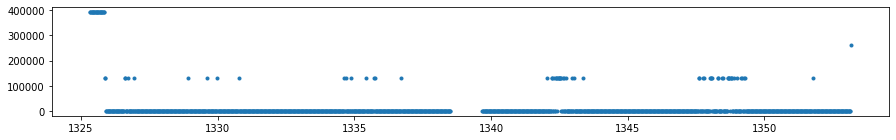

In [87]:
rando = fits.open(glob('/srv/scratch/astro/z3529659/eleanor-lite/s0001/0000/0000/2429/3868/*.fits')[0])
dat = Table.read(rando[1])
dat_pd = dat.to_pandas()
plt.figure(figsize=(15,2))
sf = dat_pd['QUALITY']
t = dat_pd['TIME']

plt.plot(t, sf, '.')

(-4, 8)

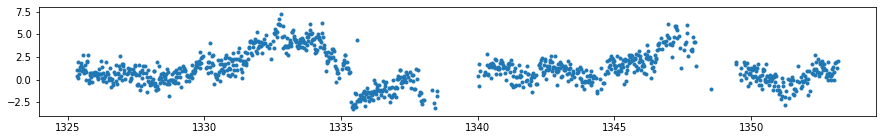

In [88]:
rando = fits.open(glob('/srv/scratch/astro/z3529659/eleanor-lite/s0001/0000/0000/2469/4341/*.fits')[0])
dat = Table.read(rando[1])
dat_pd = dat.to_pandas()
dat_pd = dat_pd[dat_pd['QUALITY'] == 0]

plt.figure(figsize=(15,2))
sf = dat_pd['PCA_FLUX']
t = dat_pd['TIME']

plt.plot(t, sf/np.nanmedian(sf), '.')
plt.ylim(-4, 8)
# negatives ?? - something wrong with background subtraction


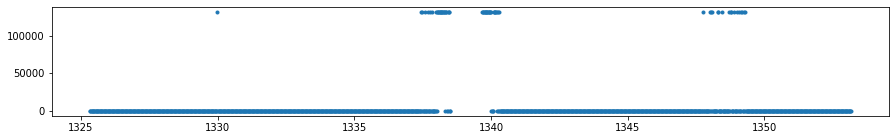

In [89]:
rando = fits.open(glob('/srv/scratch/astro/z3529659/eleanor-lite/s0001/0000/0000/2469/4341/*.fits')[0])
dat = Table.read(rando[1])
dat_pd = dat.to_pandas()
plt.figure(figsize=(15,2))
sf = dat_pd['QUALITY']
t = dat_pd['TIME']

plt.plot(t, sf, '.')

(0.9, 1.1)

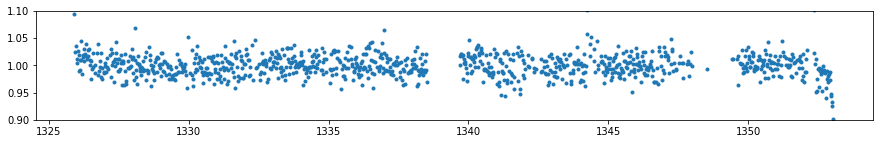

In [7]:
rando = fits.open(glob('/srv/scratch/astro/z3529659/eleanor-lite/s0001/0000/0000/2429/3869/*.fits')[0])
dat = Table.read(rando[1])
dat_pd = dat.to_pandas()
dat_pd = dat_pd[dat_pd['QUALITY'] == 0]

plt.figure(figsize=(15,2))
sf = dat_pd['PCA_FLUX']
t = dat_pd['TIME']

plt.plot(t, sf/np.nanmedian(sf), '.')
plt.ylim(0.9, 1.1)

# high variability/amplitude noise

(0.97, 1.03)

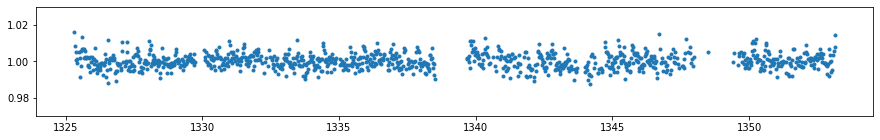

In [10]:
rando = fits.open(glob('/srv/scratch/astro/z3529659/eleanor-lite/s0001/0000/0000/2475/0171/*.fits')[0])
dat = Table.read(rando[1])
dat_pd = dat.to_pandas()
dat_pd = dat_pd[dat_pd['QUALITY'] == 0]

plt.figure(figsize=(15,2))
sf = dat_pd['PCA_FLUX']
t = dat_pd['TIME']

plt.plot(t, sf/np.nanmedian(sf), '.')
plt.ylim(0.97, 1.03)

# high variability/amplitude noise

(0.93, 1.07)

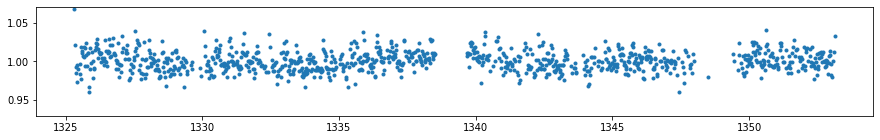

In [13]:
rando = fits.open(glob('/srv/scratch/astro/z3529659/eleanor-lite/s0001/0000/0000/2475/0165/*.fits')[0])
dat = Table.read(rando[1])
dat_pd = dat.to_pandas()
dat_pd = dat_pd[dat_pd['QUALITY'] == 0]

plt.figure(figsize=(15,2))
sf = dat_pd['PCA_FLUX']
t = dat_pd['TIME']

plt.plot(t, sf/np.nanmedian(sf), '.')
plt.ylim(0.93, 1.07)

# high variability/amplitude noise

(0.5, 1.5)

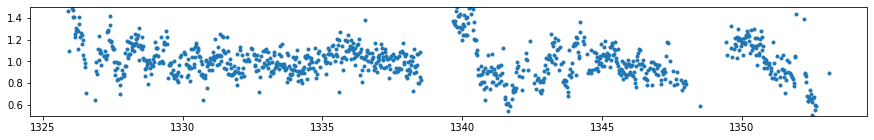

In [17]:
rando = fits.open(glob('/srv/scratch/astro/z3529659/eleanor-lite/s0001/0000/0000/2429/3871/*.fits')[0])
dat = Table.read(rando[1])
dat_pd = dat.to_pandas()
dat_pd = dat_pd[dat_pd['QUALITY'] == 0]

plt.figure(figsize=(15,2))
sf = dat_pd['PCA_FLUX']
t = dat_pd['TIME']

plt.plot(t, sf/np.nanmedian(sf), '.')
plt.ylim(0.5, 1.5)

# high amplitude, stray-light from the Earth